### Imports  
*All the Python imports go here.*

In [1]:
import os, re, math, time, glob
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import decomposition
from TextProcessor import *
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2019)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/galo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

-------------------------


## Read data

## Training and Test 

In [74]:
# df_model_training = pd.read_csv('../data/training.csv')
# df_model_test = pd.read_csv('../data/test.csv')
df_model = pd.read_csv('../data/final_ecuador_data/final_data_shuffle.csv', sep='|')
categories = ['polit', 'economi', 'educ', 'crime', 'health', 'sport']
df_model = df_model[df_model['category'].isin(categories)]

In [78]:
percent = 0.75
#df_model_training = df_model[:int(len(df_model) * percent)]
#df_model_test = df_model[int(len(df_model) * percent) + 1:]

df_model_training = df_model.sample(frac=percent, random_state=2)
df_model_test = df_model.drop(df_model_training.index, inplace=False)

df_model_training.to_csv('../data/final_ecuador_data/final_training.csv', index=False)
df_model_test.to_csv('../data/final_ecuador_data/final_test.csv', index=False)

In [76]:
df_model_training.category.value_counts(normalize=False)

polit      77
economi    77
educ       75
health     73
sport      73
crime      69
Name: category, dtype: int64

In [77]:
df_model_test.category.value_counts(normalize=False)

educ       29
crime      27
economi    27
polit      25
health     24
sport      16
Name: category, dtype: int64

# Prediction

Using the training and test dataset, we will predict the category of news.

### SVM Classifier

In [7]:
frames = [df_model_training, df_model_test]
df_model = pd.concat(frames)

In [48]:
# Create TFIDF matrix.
corpus = df_model['tokens-headline-stopwords-stemming']
vectorizer = TfidfVectorizer()
matrix = vectorizer.fit_transform(corpus)
print(matrix.shape)

(592, 1430)


In [49]:
# Split my data on training y test.
num_training = len(df_model_training)
X_train = matrix[:num_training,:]
X_test = matrix[num_training:,:]
y_train = df_model["category"].values[:num_training]
y_test = df_model['category'].values[num_training:]

In [50]:
# Create the SVM classifier
clf = SVC(probability=True, kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [51]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       crime       0.79      0.85      0.82        27
     economi       0.78      0.78      0.78        27
        educ       0.96      0.76      0.85        29
      health       0.94      0.62      0.75        24
       polit       0.57      0.84      0.68        25
       sport       0.81      0.81      0.81        16

   micro avg       0.78      0.78      0.78       148
   macro avg       0.81      0.78      0.78       148
weighted avg       0.81      0.78      0.78       148



### Any Traditional ML Classifier

### Any Neural Network Classifier

In [52]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
import plotly.graph_objs as go
import plotly.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from keras.utils import plot_model

In [64]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 300
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 15
# This is fixed.
EMBEDDING_DIM = 10

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(corpus.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1430 unique tokens.


In [65]:
X = tokenizer.texts_to_sequences(corpus.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

('Shape of data tensor:', (592, 15))


In [66]:
Y = pd.get_dummies(df_model['category'])
target_labels = Y.columns
target = Y.as_matrix()
Y = target.copy()
print('Shape of label tensor:', target.shape)

('Shape of label tensor:', (592, 6))


In [67]:
X_train = X[:num_training,:]
X_test = X[num_training:,:]
y_train = Y[:num_training]
y_test = Y[num_training:]

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

((444, 15), (444, 6))
((148, 15), (148, 6))


In [68]:
model = Sequential(name='ALG_1')
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], name='Embedding'))
model.add(SpatialDropout1D(0.2, name='SpatialDropout1D'))
model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2, name='LSTM'))
model.add(Dense(6, activation='softmax', name='Dense_softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#plot_model(model, to_file='LSTM.png',show_shapes=True, show_layer_names=True)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 15, 10)            3000      
_________________________________________________________________
SpatialDropout1D (SpatialDro (None, 15, 10)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 16)                1728      
_________________________________________________________________
Dense_softmax (Dense)        (None, 6)                 102       
Total params: 4,830
Trainable params: 4,830
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
epochs = 50
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 355 samples, validate on 89 samples
Epoch 1/50
355/355 [==============================] - 1s 4ms/step - loss: 1.7920 - acc: 0.1690 - val_loss: 1.7919 - val_acc: 0.1348
Epoch 2/50
355/355 [==============================] - 0s 190us/step - loss: 1.7896 - acc: 0.2028 - val_loss: 1.7908 - val_acc: 0.1573
Epoch 3/50
355/355 [==============================] - 0s 181us/step - loss: 1.7865 - acc: 0.2620 - val_loss: 1.7901 - val_acc: 0.1685
Epoch 4/50
355/355 [==============================] - 0s 178us/step - loss: 1.7849 - acc: 0.2732 - val_loss: 1.7893 - val_acc: 0.1573
Epoch 5/50
355/355 [==============================] - 0s 179us/step - loss: 1.7817 - acc: 0.3070 - val_loss: 1.7881 - val_acc: 0.1685
Epoch 6/50
355/355 [==============================] - 0s 189us/step - loss: 1.7787 - acc: 0.2901 - val_loss: 1.7867 - val_acc: 0.1685
Epoch 7/50
355/355 [==============================] - 0s 177us/step - loss: 1.7743 - acc: 0.2930 - val_loss: 1.7849 - val_acc: 0.1798
Epoch 8/50
355/355 

In [70]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

148/148 [==============================] - 0s 86us/step
Test set
  Loss: 1.026
  Accuracy: 0.601


In [71]:
import matplotlib.pyplot as plt

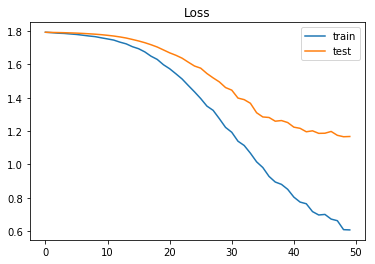

In [72]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

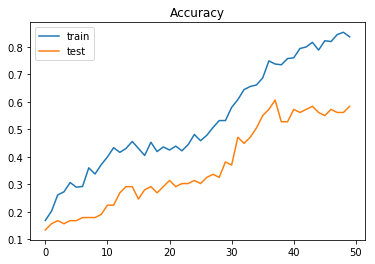

In [73]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();